In [86]:
import os
import re


import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [87]:
# Define colors for modes
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import seaborn as sns

MODE_COLORS = {"hard": "blue", "soft": "orange", "Weady et al.": "black"}
LINE_STYLES = {"$\\lambda = 10^{-2}$": "solid",
               "$\\lambda = 10^{-3}$": "dashed", "$\\lambda = 10^{-4}$": "dotted"}

In [88]:
from load_combined import load_combined

source_folders = [
    "../data/strong_scaling/",
 
]

# find recursive subfolders within source_folders
sim_dirs = []
for folder in source_folders:
    for root, dirs, files in os.walk(folder):
        # skip if /data as last part of path
        if "logs" in root or "data" in root.split(os.sep)[-1]:
            continue

        if any(f.endswith(".pvtu") for f in os.listdir(root)):
            sim_dirs.append(os.path.join(root))

particles_dict, sim_dict, params_dict = load_combined(sim_dirs, offset=0)

loading ../data/strong_scaling/1759832212508.949/output_hard/8ranks/vtk_output_hard
loading ../data/strong_scaling/1759832212508.949/output_hard/112ranks/vtk_output_hard
loading ../data/strong_scaling/1759832212508.949/output_hard/24ranks/vtk_output_hard
loading ../data/strong_scaling/1759832212508.949/output_hard/48ranks/vtk_output_hard
loading ../data/strong_scaling/1759832212508.949/output_hard/2ranks/vtk_output_hard
loading ../data/strong_scaling/1759832212508.949/output_hard/96ranks/vtk_output_hard
loading ../data/strong_scaling/1759832212508.949/output_hard/4ranks/vtk_output_hard
loading ../data/strong_scaling/1759832212508.949/output_hard/1ranks/vtk_output_hard
loading ../data/strong_scaling/1759832212508.949/output_hard/16ranks/vtk_output_hard
loading ../data/strong_scaling/1759832212508.949/output_hard/64ranks/vtk_output_hard
loading ../data/strong_scaling/1759832212508.949/output_soft/8ranks/vtk_output_soft
loading ../data/strong_scaling/1759832212508.949/output_soft/112ranks

In [89]:
# print sizte of particles_dict in MB
print(f"Loaded particles_dict with {particles_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"Loaded sim_dict with {sim_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"Loaded params_dict with {params_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Loaded particles_dict with 2357.63 MB
Loaded sim_dict with 0.53 MB
Loaded params_dict with 0.03 MB


In [90]:
sim_dict.keys()

Index(['iteration', 'simulation_time_s', 'time_since_last_log_s', 'step',
       'num_particles', 'num_constraints', 'colony_radius',
       'recursive_iterations', 'bbpgd_iterations', 'max_overlap', 'residual',
       'memory_usage_mb', 'peak_memory_mb', 'cpu_time_s', 'mpi_comm_time_s',
       'load_imbalance', 'dt_s', 'x', 'y', 'z', 'rank', 'Mode', 'Sensitivity',
       'sim_dir', 'offset'],
      dtype='object')

In [91]:
particles_dict["sim_dir"]

0          1759832212508.949
1          1759832212508.949
2          1759832212508.949
3          1759832212508.949
4          1759832212508.949
                 ...        
5014788    1759615811989.929
5014789    1759615811989.929
5014790    1759615811989.929
5014791    1759615811989.929
5014792    1759615811989.929
Name: sim_dir, Length: 5014793, dtype: object

In [92]:
particles_dict["total_ranks"]=particles_dict["Sensitivity"].str.extract(r"(\d+)ranks")

In [93]:
from scipy.optimize import curve_fit

runtimes = []
for k, g in particles_dict.groupby(["Mode", "total_ranks", "sim_dir"]):
    src = g["Sensitivity"].unique()[0]

    sim_data = sim_dict[sim_dict["Sensitivity"] == src]

    final_time = sim_data["cpu_time_s"].max()

    runtimes.append(pd.DataFrame({
        "runtime [h]": [final_time / 3600],
        "Mode": [k[0]],
        "total_ranks": [int(k[1])],
        "sim_dir": [k[2]],
    }))
runtimes = pd.concat(runtimes, ignore_index=True)


def amdahl(N, p):
    return 1 / ((1 - p) + p / N)


def compute_speedup(group):
    baseline = group[group["total_ranks"] == 1]
    baseline = baseline.iloc[0]["runtime [h]"]
    group = group.copy()
    group["speedup"] = baseline / group["runtime [h]"]

    N = group["total_ranks"].values
    S = group["speedup"].values

    # Fit p to all observed speedups
    popt, _ = curve_fit(amdahl, N, S, bounds=(0, 1))
    p_est = popt[0]

    group["amdahl"] = amdahl(N, p_est)
    group["p_est"] = p_est

    group["efficiency"] = group["speedup"] / group["total_ranks"]
    return group


runtimes = runtimes.groupby(["Mode", "sim_dir"]).apply(
    compute_speedup).reset_index(drop=True)

runtimes.sort_values(["Mode", "total_ranks"], inplace=True)
runtimes

runtimes

/tmp/ipykernel_15026/711820821.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  runtimes = runtimes.groupby(["Mode", "sim_dir"]).apply(


,runtime [h],Mode,total_ranks,sim_dir,speedup,amdahl,p_est,efficiency
0,19.743778,hard,1,1759615811989.929,1.000000,1.000000,0.947981,1.000000
9,16.871472,hard,1,1759832212508.949,1.000000,1.000000,0.944805,1.000000
19,17.633000,hard,1,old,1.000000,1.000000,0.944157,1.000000
3,8.780472,hard,2,1759615811989.929,2.248601,1.901106,0.947981,1.124300
12,9.342861,hard,2,1759832212508.949,1.805814,1.895385,0.944805,0.902907
22,8.418972,hard,2,old,2.094436,1.894220,0.944157,1.047218
5,11.800333,hard,4,1759615811989.929,1.673154,3.460034,0.947981,0.418289
14,12.039583,hard,4,1759832212508.949,1.401334,3.431757,0.944805,0.350333
24,4.753528,hard,4,old,3.709456,3.426036,0.944157,0.927364
7,5.705778,hard,8,1759615811989.929,3.460313,5.864520,0.947981,0.432539


In [94]:
for k, g in runtimes.groupby(["total_ranks", "Mode"]):
    print(k, len(g))

(np.int64(1), 'hard') 3
(np.int64(1), 'soft') 3
(np.int64(2), 'hard') 3
(np.int64(2), 'soft') 3
(np.int64(4), 'hard') 3
(np.int64(4), 'soft') 3
(np.int64(8), 'hard') 3
(np.int64(8), 'soft') 3
(np.int64(16), 'hard') 3
(np.int64(16), 'soft') 3
(np.int64(24), 'hard') 3
(np.int64(24), 'soft') 3
(np.int64(48), 'hard') 3
(np.int64(48), 'soft') 3
(np.int64(64), 'hard') 2
(np.int64(64), 'soft') 3
(np.int64(96), 'hard') 3
(np.int64(96), 'soft') 3
(np.int64(112), 'hard') 3
(np.int64(112), 'soft') 3


In [95]:
def makeplot(data, x, y, xlabel=None, ylabel=None, outname=None, variable="density",
             xscale=None, yscale=None,
             **kwargs):

    fig, ax = plt.subplots(figsize=(10, 6))
    outname = outname or f"{y}_vs_{x}.png"

    sns.lineplot(data, x=x,                 y=y,
                 hue="Mode", marker="o", ax=ax, **kwargs, lw=2, ms=10, palette=MODE_COLORS, style_order=LINE_STYLES.keys())

    if xscale:
        ax.set_xscale(xscale, base=2)
    if yscale:
        ax.set_yscale(yscale, base=2)

    ax.set_xlabel(xlabel or x, fontsize=20)
    ax.set_ylabel(ylabel or y, fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(True)
    ax.legend(fontsize=22)

    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")

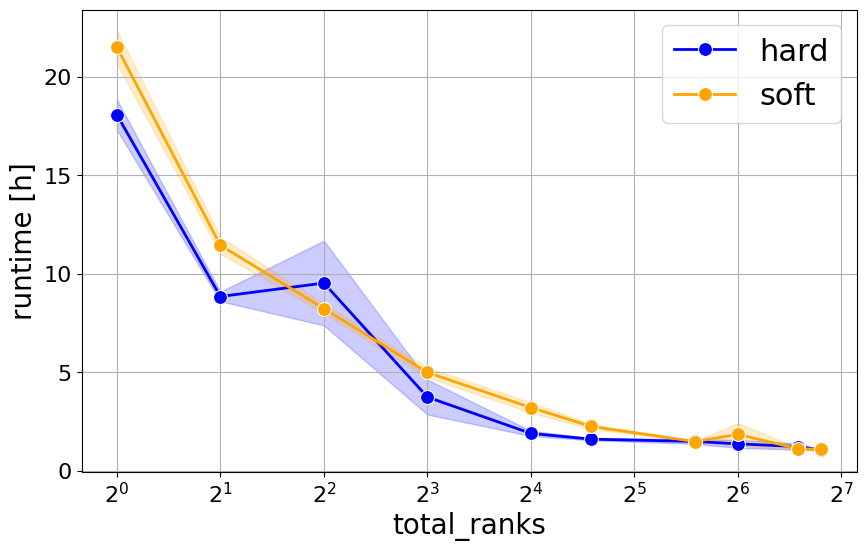

In [138]:
makeplot(runtimes, x="total_ranks", y="runtime [h]",
         outname="strong_scaling_runtime_hard_soft.png", xscale="log",  errorbar=("se",0.9))

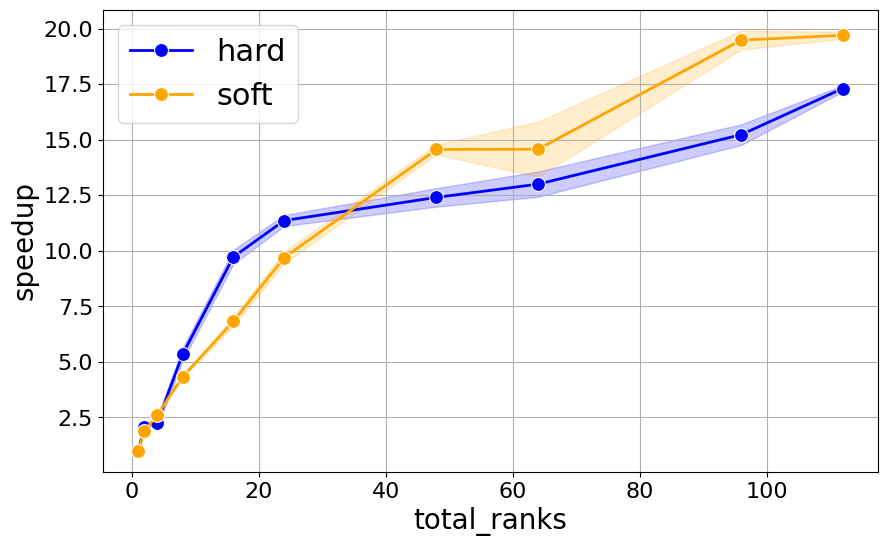

In [139]:
makeplot(runtimes, x="total_ranks", y="speedup",
         outname="strong_scaling_speedup_hard_soft.png", errorbar=("se", 0.3))